<a href="https://colab.research.google.com/github/hayunjong83/computer_vision_implement_research/blob/master/keras_official_examples/image_segmentation_with_Unet_like_arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image segmentation with a U-Net-like architecture**
---

원본 글 : [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/#download-the-data)


---

Oxford Pets 데이터셋을 처음부터 학습시키는 이미지 세그먼테이션(segmentation) 모델을 구성한다.



## 데이터 다운로드
---
[**Oxford-IIIT Pet datasets**](http://www.robots.ox.ac.uk/~vgg/data/pets/)는 37종의 개 또는 고양이에 대한 이미지 데이터다. 각 클래스는 크기, 포즈, 조명 등이 다른 약 200장의 이미지로 구성되어 있다. 정답(ground truth)은 클래스(species) 레이블, 머리 위치와 이미지에 대한 픽셀 분할영상(pixel segmentation)을 제공한다.(*각각 classification, object detection, semantic segmentation을 위해서 존재한다.*)

이 예제는 [데이터](http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz)와 [정답](http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz)을 **curl** 명령어로 다운받고, 압축을 푼다. 직접 로컬에서 작업할 경우, 편하게 데이터를 받을 수 있게 데이터셋 공식 홈페이지와 데이터 각각에 대한 링크를 달아놓았다.

In [1]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  70.0M      0  0:00:10  0:00:10 --:--:-- 76.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  46.5M      0 --:--:-- --:--:-- --:--:-- 46.5M


## 입력 이미지와 타겟 세그먼테이션 마스크의 경로 준비
---
이미지 데이터는 **.jpg** 확장자로 되어 있다. 정답을 기록한 주석(annotation)데이터에는 파일명이 같은 이미지에 대한 breed 명, head ROI 위치, 포즈 등에 대한 정보를 **.xml**파일로 갖고 있다(./xmls).
또 픽셀 레벨 세그먼테이션 정보는 동일한 파일명의 **./png**파일로 제공해준다(./trimaps). 

이 예제는 세그먼테이션을 수행하기 위한 것으로 trimap 정보를 가지고 온다.

In [2]:
import os

input_dir = "images/"
target_dir ="annotations/trimaps/"

img_size = (160, 160)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples: ", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  print(input_path, "|", target_path)

Number of samples:  7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## 입력 이미지와 해당 세그먼테이션 마스크 확인
---
하나의 이미지를 골라서, 원본 이미지와 그 세그먼테이션 결과가 어떤지 시각화하여 비교해본다.

PIL(Python Image Library)에는 미리 정의된 이미지 처리 연산들이 있는데, 여기서는 세그먼테이션 결과가 명확하게 보이도록 **PIL.ImageOps.autocontrast()**를 통해 대비도를 높인다.

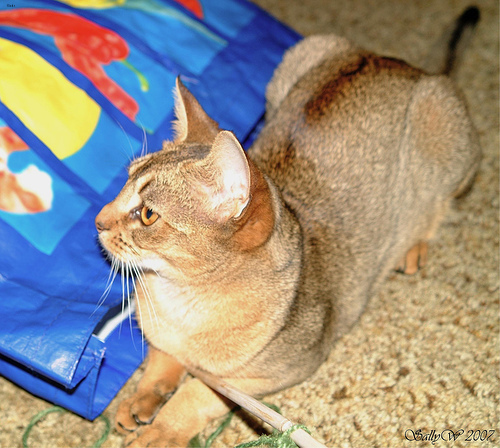

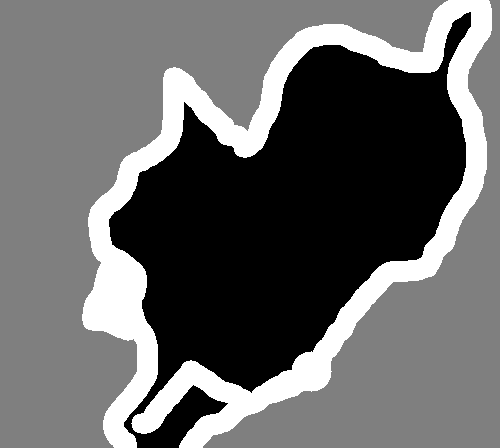

In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display one input image 
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Sequence 클래스를 통한 데이터셋 처리
---
[**keras.utils.Sequence()**](https://keras.io/api/utils/python_utils/#sequence-class)클래스를 이용하여 배치 단위로 원본 이미지와 타겟 세그먼테이션 이미지를 연관짓는다. 이렇게 되면 데이터셋을 벡터화해서 로드할 수 있으므로, 안전하게 멀티 프로세싱을 수행할 수 있다.

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """ Helper to iterate over the data (as Numpy arrays). """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        
        y = np.zeros((batch_size,)+ self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x,y

## U-Net Xception-style 모델 구성
---
대칭된 'U' 형태로 **압축경로(contracting path)**와 **확장경로(expansive path)**로 구성된 U-Net은 의생명 영상 세그먼테이션(biomedical image segmentation)을 위해 제안된 CNN이다. 데이터 확장(data augmentation)을 이용해서 end-to-end로 빠른 학습이 가능하며, 세그먼테이션에서 높은 성능을 보인다.

이 예제에서는 컨볼루션 층(Conv2D)를 **깊이별 분리 합성곱(depthwise separable convolution)**을 수행하는 *SeparableConv2D*로 바꿔서 공간합습과 채널학습을 분리하였다. 

U-Net의 중요한 특징인 다운샘플링 구간으로부터 *업샘플링 구간으로의 스킵 커넥션(skip connection)*은 적용하지 않았지만, 대신 Xception처럼 잔차학습(residual learning)을 적용하였다.

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [6]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

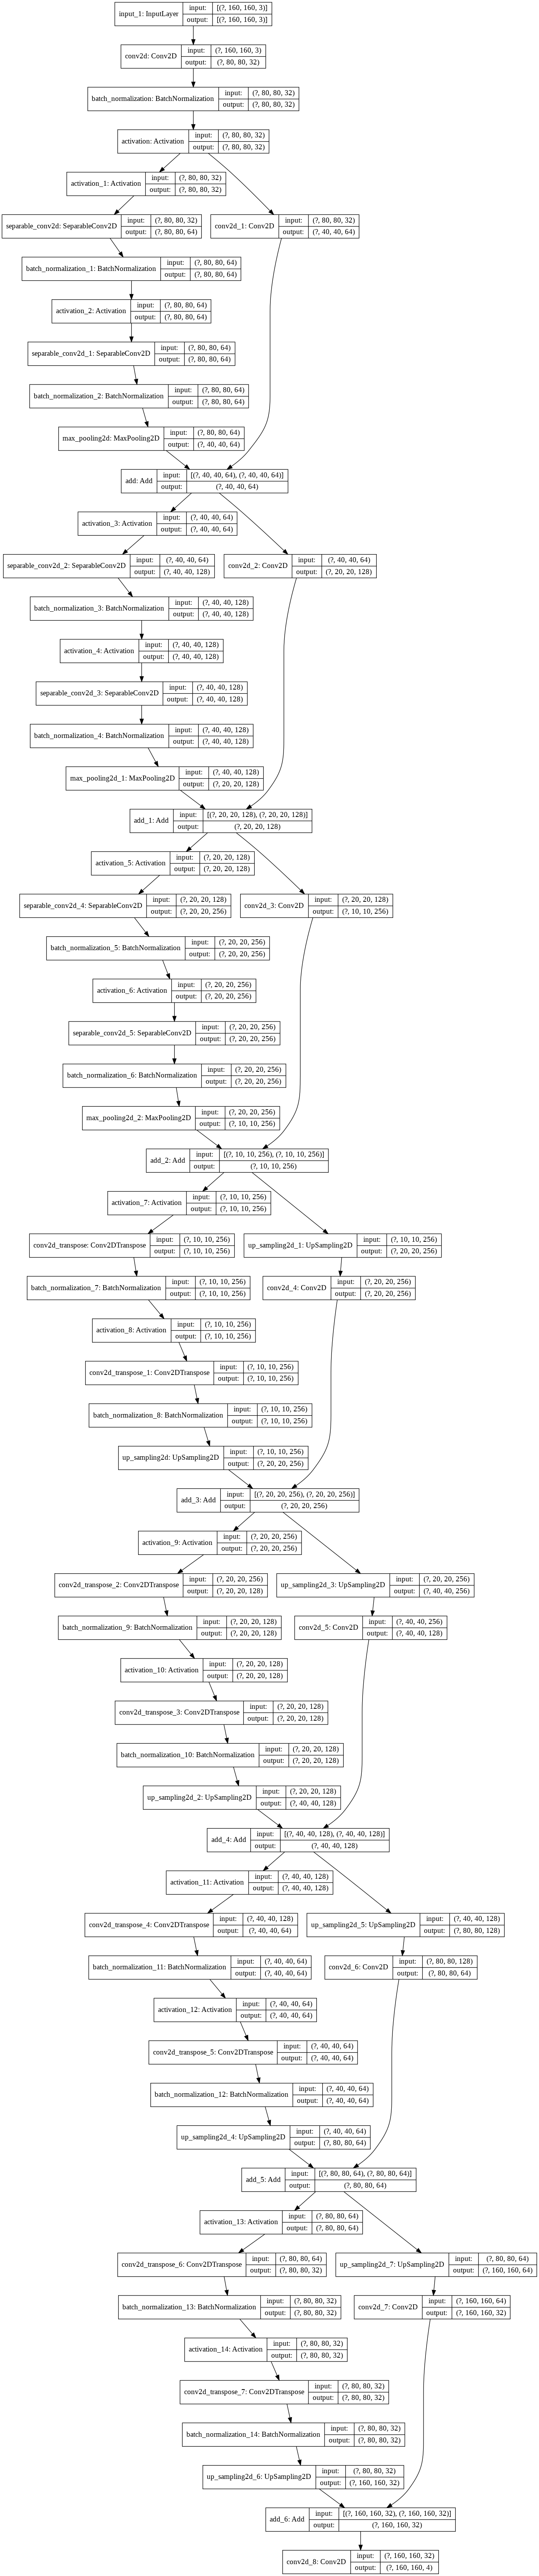

In [7]:
keras.utils.plot_model(model, show_shapes=True)

## 검증 데이터 준비
---
데이터와 정답 데이터를 섞은 뒤, 마지막 1,000개를 검증 데이터로 설정한다.

데이터 시퀀스 생성은 위에서 만든 OxfordPets()클래스를 사용한다.

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 모델 훈련
---

In [9]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integer
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
             keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 52s 260ms/step - loss: 0.9829 - val_loss: 2.1627
Epoch 2/15
199/199 [==============================] - 51s 255ms/step - loss: 0.5112 - val_loss: 1.9945
Epoch 3/15
199/199 [==============================] - 51s 255ms/step - loss: 0.4369 - val_loss: 0.4149
Epoch 4/15
199/199 [==============================] - 51s 255ms/step - loss: 0.3886 - val_loss: 0.4069
Epoch 5/15
199/199 [==============================] - 51s 254ms/step - loss: 0.3525 - val_loss: 0.4070
Epoch 6/15
199/199 [==============================] - 51s 256ms/step - loss: 0.3237 - val_loss: 0.3966
Epoch 7/15
199/199 [==============================] - 51s 256ms/step - loss: 0.2998 - val_loss: 0.3591
Epoch 8/15
199/199 [==============================] - 51s 254ms/step - loss: 0.2941 - val_loss: 0.3918
Epoch 9/15
199/199 [==============================] - 51s 254ms/step - loss: 0.2590 - val_loss: 0.3979
Epoch 10/15
199/199 [==============================] - 51s 254ms/step - l

## 예측 결과 시각화
---

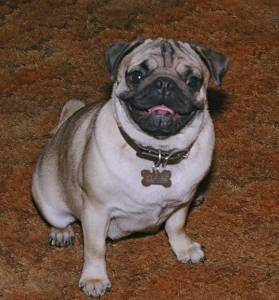

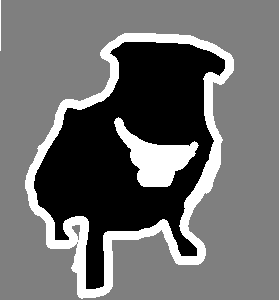

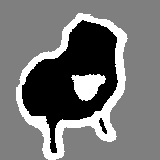

In [11]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)     # Note that the model only sees inputs at 150 x 150.